In [111]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

In [112]:
PATH = 'Crop_recommendation.csv'
df = pd.read_csv(PATH)

In [113]:
df.head()

,N,P,K,Ph,temperature,humidity,rainfall,label
0,100.0,55.0,165.0,5.7,25.418448,61.759979,1050.0,Dragon Fruit
1,100.0,60.0,160.0,6.5,25.418448,61.759979,900.0,Dragon Fruit
2,90.0,30.0,160.0,6.4,25.418448,61.759979,900.0,Dragon Fruit
3,80.0,40.0,150.0,6.0,25.418448,61.759979,800.0,Dragon Fruit
4,80.0,45.0,150.0,6.0,25.418448,61.759979,800.0,Dragon Fruit


In [114]:
df.tail()

,N,P,K,Ph,temperature,humidity,rainfall,label
4089,90.0,34.0,32.0,6.780064,26.774637,66.413269,187.879807,Wheat
4090,90.0,15.0,27.0,6.086922,27.417112,56.636362,187.879807,Rice
4091,90.0,33.0,30.0,6.362608,24.131797,67.225123,187.879807,Rice
4092,90.0,32.0,34.0,6.758793,26.272418,52.127394,187.879807,Wheat
4093,90.0,18.0,30.0,6.779833,23.603016,60.396475,187.879807,Wheat


In [115]:
df.size

32752

In [116]:
df.shape

(4094, 8)

In [117]:
df.columns

Index(['N', 'P', 'K', 'Ph', 'temperature', 'humidity', 'rainfall', 'label'], dtype='object')

In [118]:
print(f"Total no. of crops : {len(df['label'].unique())}")


Total no. of crops : 98


In [119]:

print(df.dtypes)


N              float64
P              float64
K              float64
Ph             float64
temperature    float64
humidity       float64
rainfall       float64
label           object
dtype: object


In [120]:
df['label'].value_counts()
df.columns = df.columns.str.lower()


<Axes: >

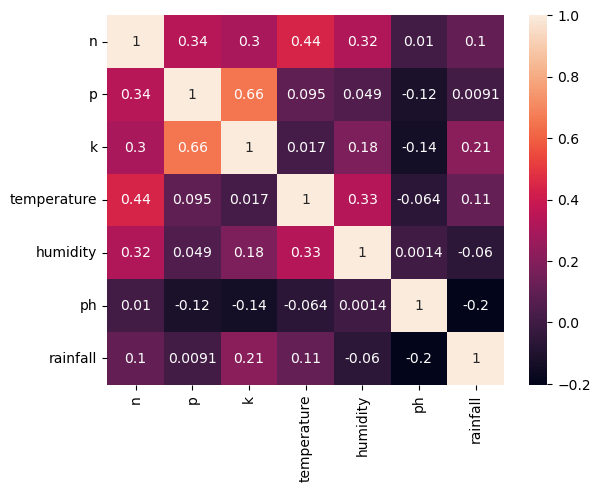

In [121]:
features = df[['n', 'p', 'k', 'temperature', 'humidity', 'ph', 'rainfall']]
sns.heatmap(features.corr(),annot=True)

In [122]:
features = df[['n','p','k','ph','temperature','humidity','rainfall']]
target = df['label']

In [123]:
# Encode string labels into numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target_encoded = le.fit_transform(target)

In [124]:
# Initializing empty lists to append all models name and corresponding name
acc = []
model = []

In [125]:
# Splitting into train and test data

from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    features, target_encoded, test_size=0.2, random_state=42, stratify=target_encoded
)

# XGBOOST for prediction 


In [131]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

XGBoostModel = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

# Fit the model
XGBoostModel.fit(Xtrain, Ytrain)

# Predict on test set
predicted_values = XGBoostModel.predict(Xtest)

# Convert back to original crop names
predicted_values_names = le.inverse_transform(predicted_values)
Ytest_names = le.inverse_transform(Ytest)

# Accuracy
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('XGBoost')
print("XGBoost Accuracy is: ", x)

# Classification report
print(classification_report(Ytest_names, predicted_values_names))

XGBoost Accuracy is:  0.9572649572649573
                                 precision    recall  f1-score   support

                      Aloe Vera       0.50      1.00      0.67         1
             Amaranth (Rajgira)       0.25      1.00      0.40         1
                    Ashwagandha       0.00      0.00      0.00         1
                      Asparagus       0.00      0.00      0.00         1
                        Avocado       1.00      1.00      1.00         1
                         Bamboo       1.00      1.00      1.00         1
                         Banana       1.00      1.00      1.00         1
                         Barley       1.00      1.00      1.00         1
                Barnyard Millet       1.00      1.00      1.00         1
                    Bittergourd       1.00      1.00      1.00         1
                      Blackgram       1.00      1.00      1.00         1
                    Blackpepper       1.00      1.00      1.00         2
         

In [138]:
# Cross validation score (XGBoost)
score = cross_val_score(XGBoostModel, features, target_encoded, cv=5)
print("5-Fold CV Score: ", score)
print("Mean CV Accuracy: ", score.mean())

5-Fold CV Score:  [0.92307692 0.98534799 0.95848596 0.96581197 0.96210269]
Mean CV Accuracy:  0.9589651044418771


# Saving trained Xgboost

In [141]:
import pickle
# Dump the trained XGBOOST classifier with Pickle
NB_pkl_filename = 'crop_prediction.pkl'
# Open the file to save as pkl file
NB_Model_pkl = open(NB_pkl_filename, 'wb')
pickle.dump(XGBoostModel, NB_Model_pkl)
# Close the pickle instances
NB_Model_pkl.close()

NB_le_filename = 'label_encoder.pkl'
NB_le_pkl = open(NB_le_filename, 'wb')
pickle.dump(le, NB_le_pkl)
NB_le_pkl.close()

# Making a prediction

In [142]:
import pickle
import numpy as np

# Load trained model
with open('crop_prediction.pkl', 'rb') as f:
    XGBoostModel = pickle.load(f)

# Load label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)
    
data = np.array([[98, 47, 37, 23.48381344, 81.33265073, 7.375482851, 224.0581164]])
    
pred_id = XGBoostModel.predict(data)[0]
crop_name = label_encoder.inverse_transform([pred_id])[0]

print("Predicted Crop:", crop_name)


Predicted Crop: Cotton
